# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

Group 15: William Jones, Elliot Leishman, Tristan Pang and Aidan Garrity

## General Setup

In [65]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

In [66]:
# Load data
data = pd.read_csv("the_office.csv")

After making sure that all the necessary libraries or submodules are uploaded here, please follow the given skeleton to create your project report. 
- Your completed assignment must follow this structure 
- You should not add or remove any of these sections, if you feel it is necessary you may add extra subsections within each (such as *2.1. Encoding*). 

**Do not forget to remove the instructions for each section in the final document.**

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

### 2.1 A brief overview of the data

In [67]:
# print head and tail of dataset
display(data)

# describe the data-types of the dataset
display(data.info())

# give the mean, variance etc. of the numeric values in the dataset
display(data.describe().round(2))

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...
2,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
3,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
4,1,5,Basketball,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,9,19,Stairmageddon,Matt Sohn,Dan Sterling,8.0,1484,2013-04-11,273,59,2965,24,Andy;Angela;Creed;Dwight;Erin;Jim;Kevin;Meredi...
182,9,20,Paper Airplane,Jesse Peretz,Halsted Sullivan;Warren Lieberstein,8.0,1482,2013-04-25,234,48,2564,27,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...
183,9,21,Livin' the Dream,Jeffrey Blitz,Nicki Schwartz-Wright,8.9,2041,2013-05-02,382,33,4333,20,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...
184,9,22,A.A.R.M,David Rogers,Brent Forrester,9.3,2860,2013-05-09,501,54,4965,30,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 19.0+ KB


None

,season,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char
count,186.00,186.00,186.00,186.00,186.00,186.00,186.00,186.00
mean,5.46,12.48,8.25,2129.54,296.40,50.15,3053.51,20.69
std,2.40,7.23,0.54,790.79,82.00,23.94,799.27,5.09
min,1.00,1.00,6.70,1393.00,131.00,11.00,1098.00,12.00
25%,3.00,6.00,7.90,1628.50,255.25,34.00,2670.25,17.00
50%,6.00,12.00,8.20,1954.00,281.00,46.00,2872.50,20.00
75%,7.75,18.00,8.60,2385.00,314.50,60.00,3141.00,23.00
max,9.00,28.00,9.70,7934.00,625.00,166.00,6076.00,54.00


There are thirteen columns in our dataset, none of which have null values. This tells us we do not need to do any cleaning regarding null values, but we can't say much about outliers at the moment. 

Looking at the columns, we choose to omit the 'seasons', 'episode', 'episode_name' and 'air_date' columns because these are variables outside of our control.

In [68]:
# drop irrelevant columns
data = data.drop(columns=['season', 'episode', 'episode_name', 'air_date'])

In [102]:
test = data.iloc[0].writer

def reorder(names):
    list_names = list(np.sort(names.split(";")))
    print(list_names)
    names = ";".join(list_names)
    return names

print(test)
print(reorder(test))

Ricky Gervais;Stephen Merchant;Greg Daniels
['Greg Daniels', 'Ricky Gervais', 'Stephen Merchant']
Greg Daniels;Ricky Gervais;Stephen Merchant


### 2.2 Correlation 

C:\Users\Will\AppData\Local\Temp\ipykernel_15112\4209251908.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot = True, fmt = '.2f', linewidths = 2)


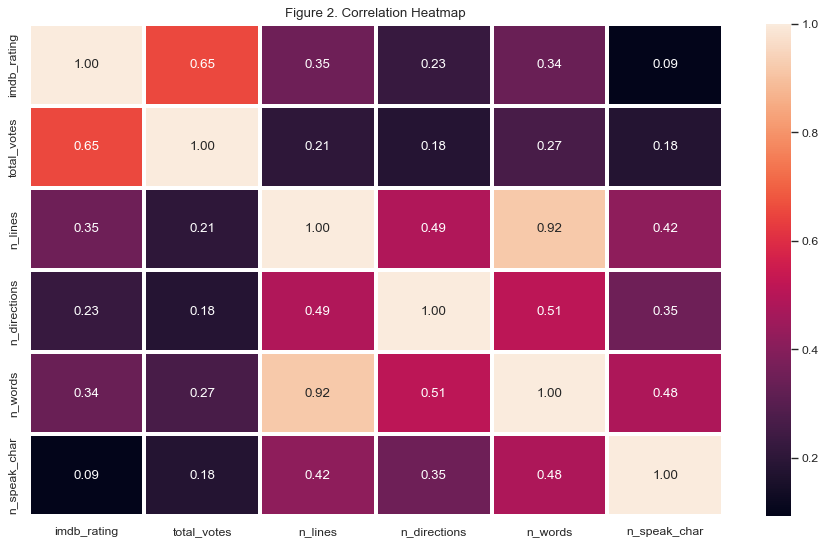

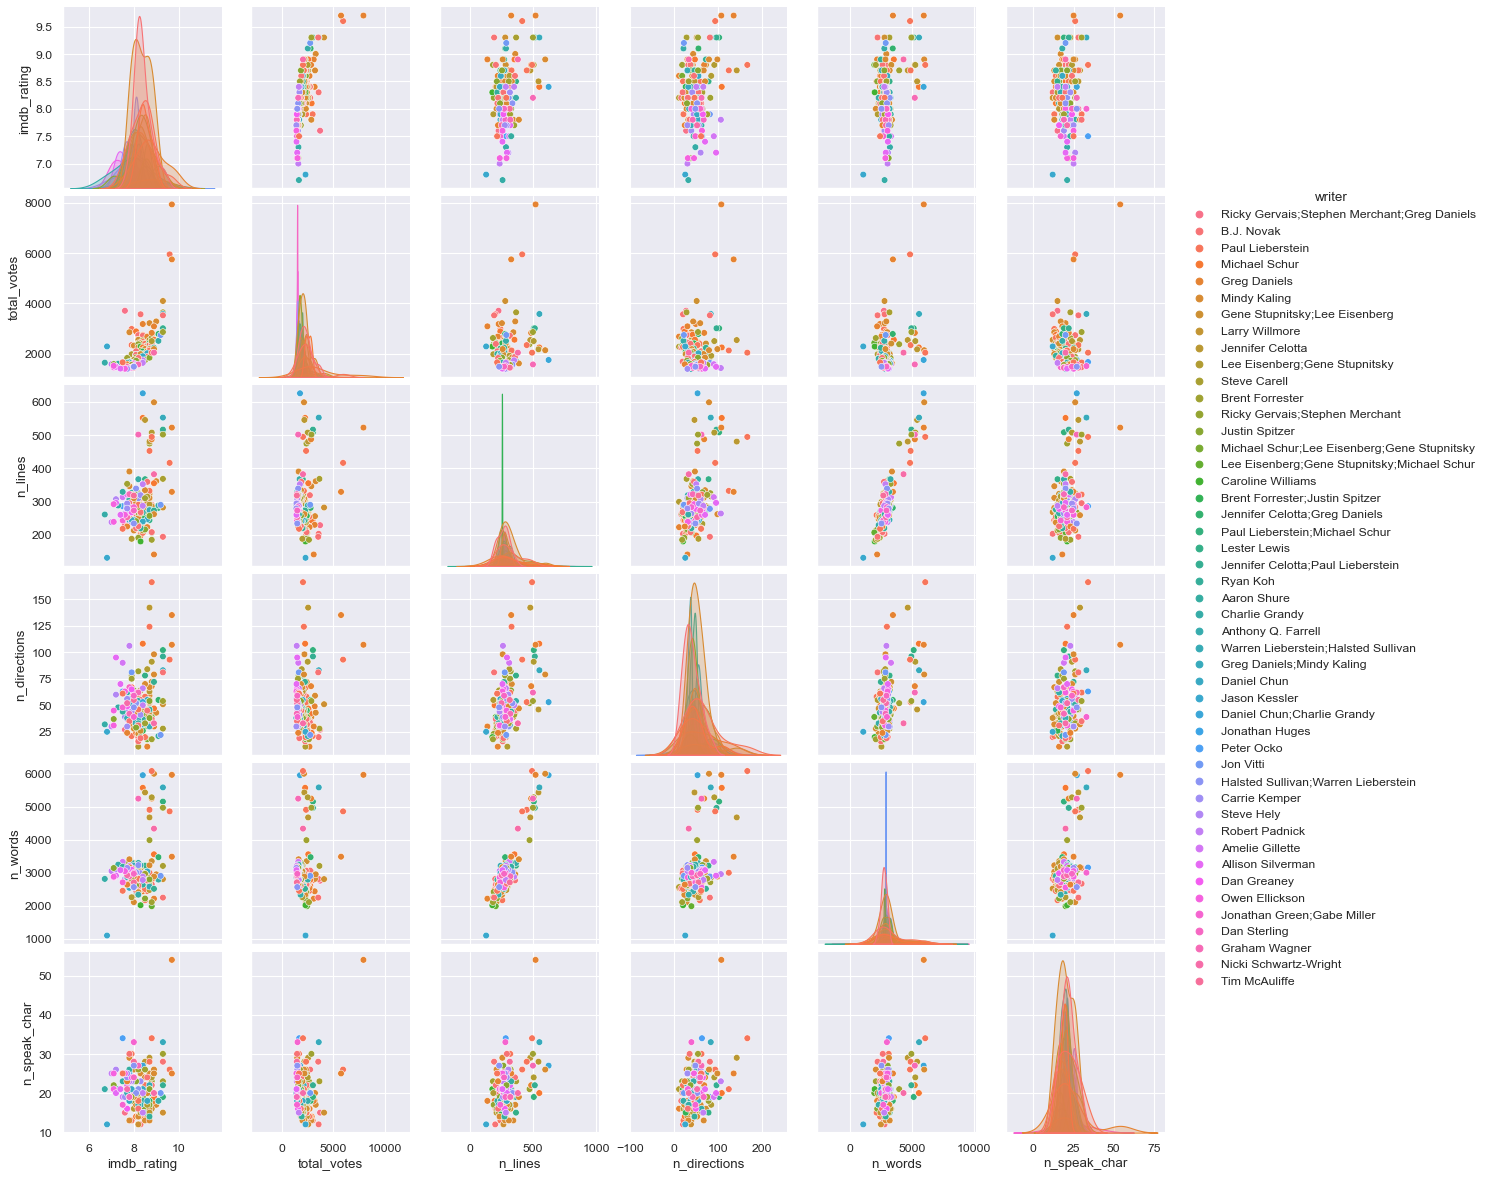

In [69]:
sns.set(rc={'figure.figsize': (14, 8)})

# Correlation heatmap 
sns.heatmap(data.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Figure 2. Correlation Heatmap")
plt.show()

# Correlation pairplot
sns.pairplot(data, hue = 'writer')

We see that 'n_words' and 'n_lines' have a strong, positive correlation, therefore we may want to only include one in our model to reduce the workload.

The next highest postive correlation is between 'total_votes' and 'imbd_rating'. Since imdb rating is what we want to maximise we would expect our model to also 

### 2.3 Diagnostic Plots

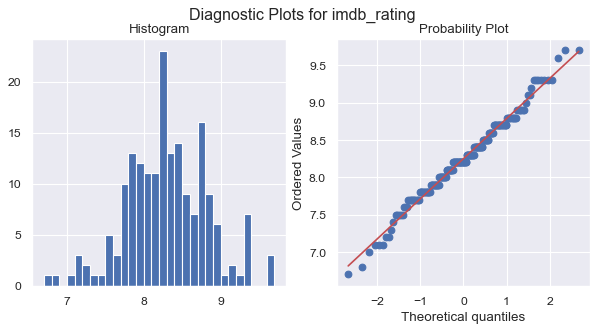

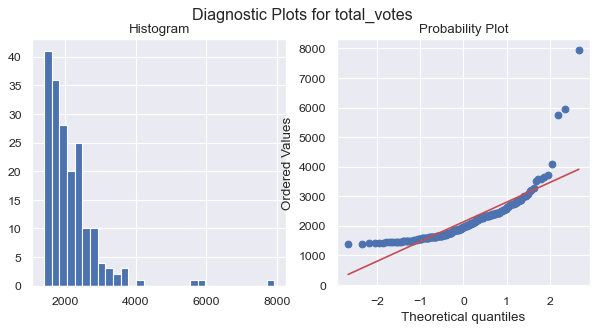

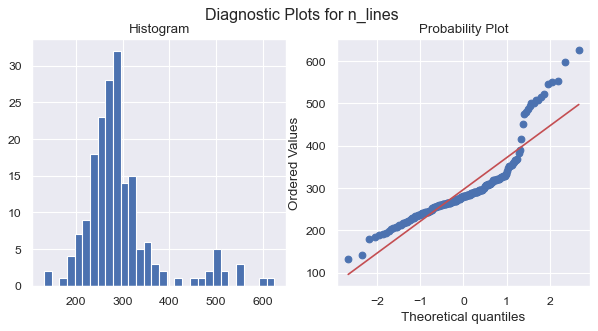

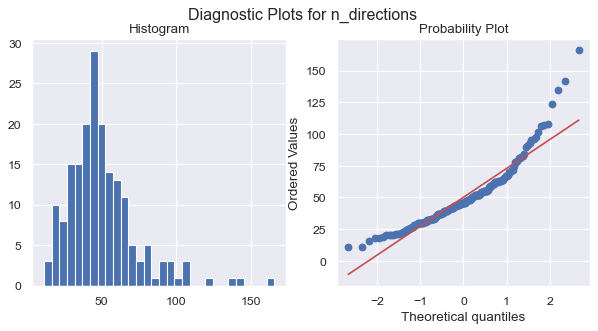

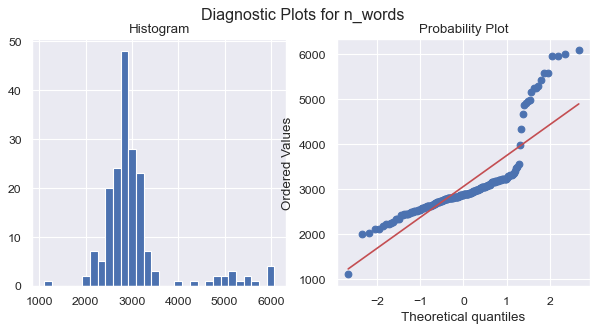

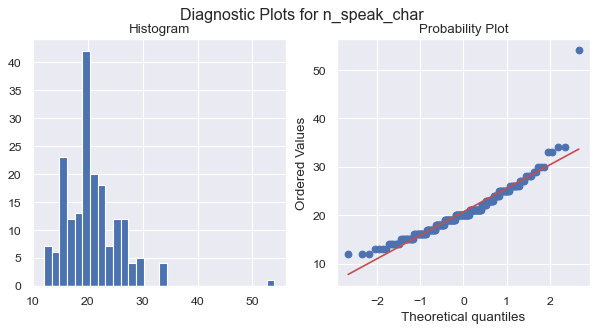

In [83]:
# Distributions - from Python Feature Engineering Cookbook
def diagnostic_plots(df, variable): 
    plt.figure(figsize=(9,4)) 
    plt.subplot(1, 2, 1) 
    df[variable].hist(bins=30)
    plt.title("Histogram")
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt) 
    plt.suptitle("Diagnostic Plots for {}".format(variable))
    plt.show()

for variable_name in data.select_dtypes(exclude = 'object'): # excludes columns with data type object, i.e. only investigate numeric values
    diagnostic_plots(data, variable_name)

Note that imbd rating and n_speak_char are 'close' to being normally distributed

C:\Users\Will\AppData\Local\Temp\ipykernel_15112\3774527254.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  chars = pd.get_dummies(chars.apply(pd.Series).stack()).sum(level=0)


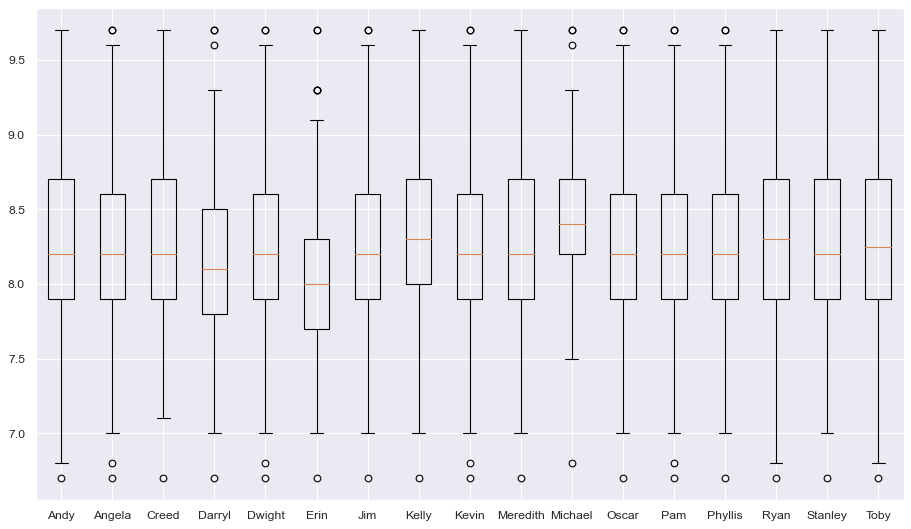

In [71]:
# Investigating effect of characters on imdb rating
chars = data['main_chars']
chars = chars.str.split(';', expand = False)
chars = pd.get_dummies(chars.apply(pd.Series).stack()).sum(level=0)

chars2 = pd.merge(data['imdb_rating'], chars, left_index=True, right_index=True)

plotting=[]
for character in chars:
    condition = character + '==1'
    plotting.append(chars2.query(condition)['imdb_rating'])
plt.boxplot(plotting)
plt.xticks(np.arange(1,18), chars.columns)
plt.show()

In [72]:
chars2.sort_values(by = ['imdb_rating'])

,imdb_rating,Andy,Angela,Creed,Darryl,Dwight,Erin,Jim,Kelly,Kevin,Meredith,Michael,Oscar,Pam,Phyllis,Ryan,Stanley,Toby
157,6.7,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1
103,6.8,1,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1
146,7.0,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0
160,7.1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,0
167,7.1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,9.3,1,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,0
59,9.3,1,1,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0
77,9.6,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0
135,9.7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


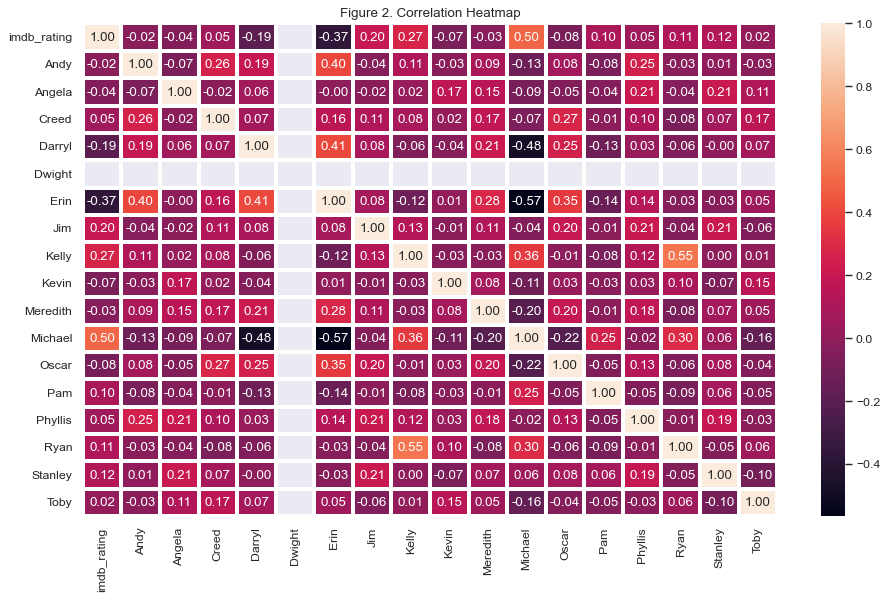

Andy        143
Angela      171
Creed       131
Darryl      105
Dwight      186
Erin         98
Jim         185
Kelly       142
Kevin       180
Meredith    131
Michael     137
Oscar       164
Pam         182
Phyllis     165
Ryan        139
Stanley     165
Toby        108
dtype: int64

In [73]:
# Correlation
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(chars2.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Figure 2. Correlation Heatmap")
plt.show()
chars.sum()

/var/folders/pg/_8g2r3zj2sz4xg237h264xjw0000gn/T/ipykernel_43311/3116571557.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  writers[i] = writers[i].replace(' ','')
/var/folders/pg/_8g2r3zj2sz4xg237h264xjw0000gn/T/ipykernel_43311/3116571557.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  writers[i] = writers[i].replace('.','')
/var/folders/pg/_8g2r3zj2sz4xg237h264xjw0000gn/T/ipykernel_43311/3116571557.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

['RickyGervais;StephenMerchant;GregDaniels' 'BJNovak' 'PaulLieberstein'
 'MichaelSchur' 'GregDaniels' 'MindyKaling' 'GeneStupnitsky;LeeEisenberg'
 'LarryWillmore' 'JenniferCelotta' 'LeeEisenberg;GeneStupnitsky'
 'SteveCarell' 'BrentForrester' 'RickyGervais;StephenMerchant'
 'JustinSpitzer' 'MichaelSchur;LeeEisenberg;GeneStupnitsky'
 'LeeEisenberg;GeneStupnitsky;MichaelSchur' 'CarolineWilliams'
 'BrentForrester;JustinSpitzer' 'JenniferCelotta;GregDaniels'
 'PaulLieberstein;MichaelSchur' 'LesterLewis'
 'JenniferCelotta;PaulLieberstein' 'RyanKoh' 'AaronShure' 'CharlieGrandy'
 'AnthonyQFarrell' 'WarrenLieberstein;HalstedSullivan'
 'GregDaniels;MindyKaling' 'DanielChun' 'JasonKessler'
 'DanielChun;CharlieGrandy' 'JonathanHuges' 'PeterOcko' 'JonVitti'
 'HalstedSullivan;WarrenLieberstein' 'CarrieKemper' 'SteveHely'
 'RobertPadnick' 'AmelieGillette' 'AllisonSilverman' 'DanGreaney'
 'OwenEllickson' 'JonathanGreen;GabeMiller' 'DanSterling' 'GrahamWagner'
 'NickiSchwartzWright' 'TimMcAuliffe']
  

/var/folders/pg/_8g2r3zj2sz4xg237h264xjw0000gn/T/ipykernel_43311/3116571557.py:10: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  writers = pd.get_dummies(writers.apply(pd.Series).stack()).sum(level=0)


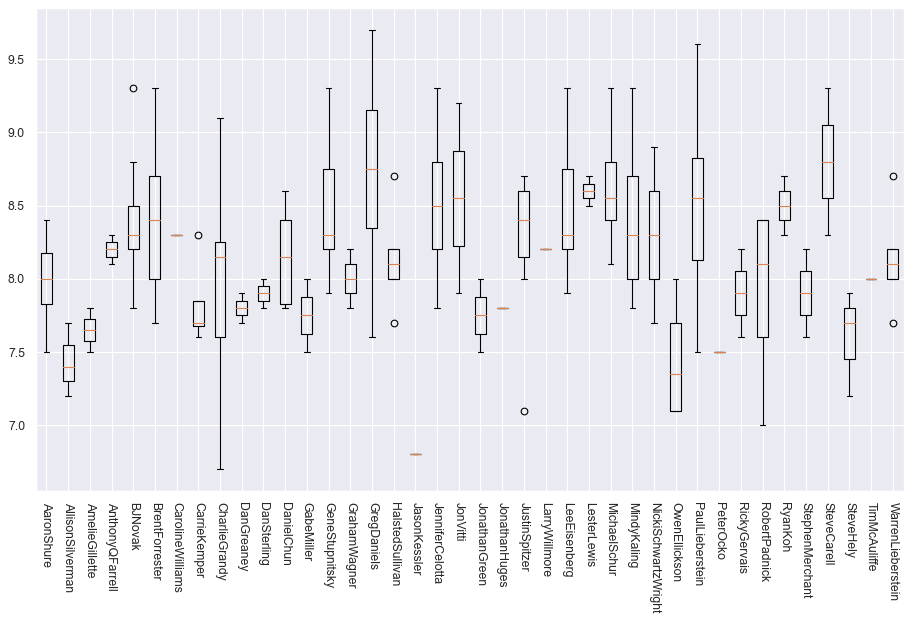

In [85]:
writers = data['writer']

for i in range(len(writers)):
    writers[i] = writers[i].replace(' ','')
    writers[i] = writers[i].replace('.','')
    writers[i] = writers[i].replace('-','')
print(writers.unique())
writers = writers.str.split(';',expand=False)

writers = pd.get_dummies(writers.apply(pd.Series).stack()).sum(level=0)
writers2 = pd.merge(data['imdb_rating'], writers, left_index=True, right_index=True)

print(writers2)
plotting=[]
for writer in writers:
    condition = writer + '==1'
    plotting.append(writers2.query(condition)['imdb_rating'])
plt.boxplot(plotting)
plt.xticks(np.arange(1,41), writers.columns)
plt.xticks(rotation = 270)
plt.show()

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

<span style="color:red">
I believe the plan is to use LASSO regression as it will perform feature selection which will improve interpretability.

'Ridge regression is useful when there is a concern about multicollinearity, and Lasso regression is useful when there are many predictors and some are suspected to be irrelevant or have little effect on the outcome.'

Should we use Cross-Validation to reduce variability in model fit and hence validation error?

A proposal for a general section plan:

    - Start with a simple general linear model with all the shit in it. We can use this as a baseline to show we are justified in making a more complicated model.
    - Make a LASSO model to get rid of un-necessary features
    - Maybe look into nonlinear or polynomial regression?

Other General things:

    - Should we consider named character in the main model, or should we instead, predict best number of characters and then try to find which characters they should be?
    - Should probably use the annoying SKlearn pipelines 
    - Comment code @Tristan Pang



Finally dont forget to 'regress the regression',

Your captian.

</span>

Import the get_coefs and model_fit functions from Workshop 5. This will allow us to evaluate our model fit and stuff.

In [74]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

In [75]:
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

In [76]:
# Splitting into test and train data
from sklearn.model_selection import train_test_split

X = data.drop('imdb_rating', axis = 1) # Set of features
X_ = pd.merge(X, chars, left_index=True, right_index=True)

y = data['imdb_rating']

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.20)
X_test.head()

,director,writer,total_votes,n_lines,n_directions,n_words,n_speak_char,main_chars,Andy,Angela,...,Kelly,Kevin,Meredith,Michael,Oscar,Pam,Phyllis,Ryan,Stanley,Toby
179,Paul Lieberstein,Paul Lieberstein,1656,218,61,2451,25,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...,1,1,...,0,1,1,0,1,1,1,0,1,0
79,Ken Kwapis,Mindy Kaling,1808,252,60,2412,17,Angela;Creed;Dwight;Jim;Kelly;Kevin;Meredith;M...,0,1,...,1,1,1,1,1,1,1,0,1,0
135,Paul Feig,Greg Daniels,5749,329,135,3483,25,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly...,1,1,...,1,1,1,1,1,1,1,1,1,1
69,David Rogers,Anthony Q. Farrell,1962,295,44,2791,17,Andy;Creed;Darryl;Dwight;Jim;Kelly;Kevin;Mered...,1,0,...,1,1,1,1,1,1,1,1,1,0
19,Victor Nelli Jr.,Paul Lieberstein,2342,261,67,2758,21,Angela;Creed;Darryl;Dwight;Jim;Kelly;Kevin;Mic...,0,1,...,1,1,0,1,1,1,1,1,1,1


In [77]:
print(chars.shape)
np.linalg.matrix_rank(chars)
# no rank deficiency?? - I think it might have automatically set Dwight as the reference configuration

(186, 17)


17

In [78]:
# Linear regression - move to top?
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Define headers to regress on
head0 = ['total_votes', 'n_lines', 'n_directions', 'n_words', 'n_speak_char']
head = list(chars.keys()) + head0

# get regressing cols
X_train_ = X_train[head]
X_test_ = X_test[head]

# regress the regression 
test_model = LinearRegression()
test_model.fit(X_train_,y_train)

# use the regressed regression to predict
y_train_pred = test_model.predict(X_train_)
y_test_pred = test_model.predict(X_test_)

# Rsquared
print(r'Train $R^2$', r2_score(y_train, y_train_pred))
print(r'Test $R^2$', r2_score(y_test, y_test_pred))

# coefficients of regression
print(test_model.intercept_)
coeffs = pd.DataFrame(test_model.coef_, head, columns=['Coefficients'])
coeffs

Train $R^2$ 0.6222587608727743
Test $R^2$ 0.47465168462286333
5.815261327444507


,Coefficients
Andy,1.801016e-01
Angela,-1.876922e-01
Creed,8.093319e-02
Darryl,1.121683e-03
Dwight,-7.573803e-15
Erin,-1.030450e-01
Jim,1.413321e+00
Kelly,1.873331e-01
Kevin,-4.449370e-02
Meredith,6.555027e-02


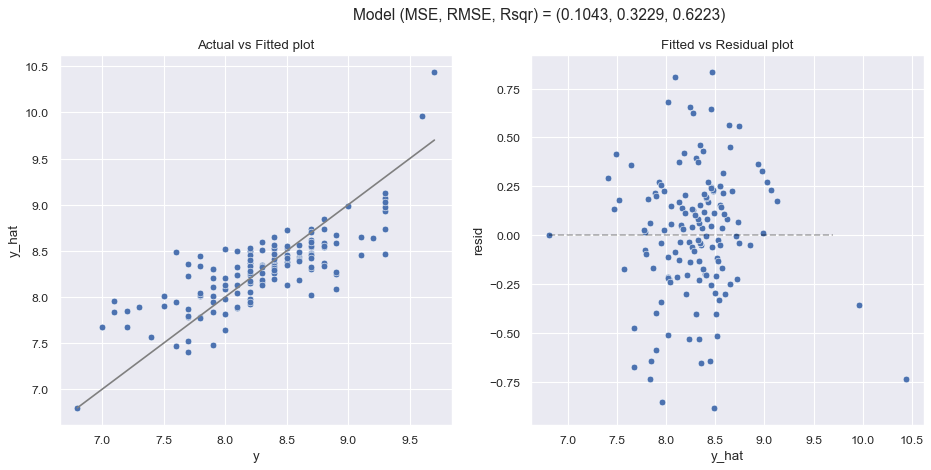

[ 5.81526133e+00  1.80101578e-01 -1.87692204e-01  8.09331886e-02
  1.12168326e-03 -7.57380270e-15 -1.03044985e-01  1.41332057e+00
  1.87333141e-01 -4.44936977e-02  6.55502670e-02  1.94169249e-01
 -4.79057229e-02 -4.22326363e-02  2.00279218e-02 -1.01974198e-01
  3.75920307e-02  5.21109449e-02  3.94108324e-04  2.63373669e-03
 -8.25556100e-04 -1.79553993e-04 -7.85004397e-03]


In [79]:
model_fit(test_model, X_train_, y_train, plot = True)
print(get_coefs(test_model))



Train $R^2$ 0.4645424710946221
Test $R^2$ 0.5036452085627924


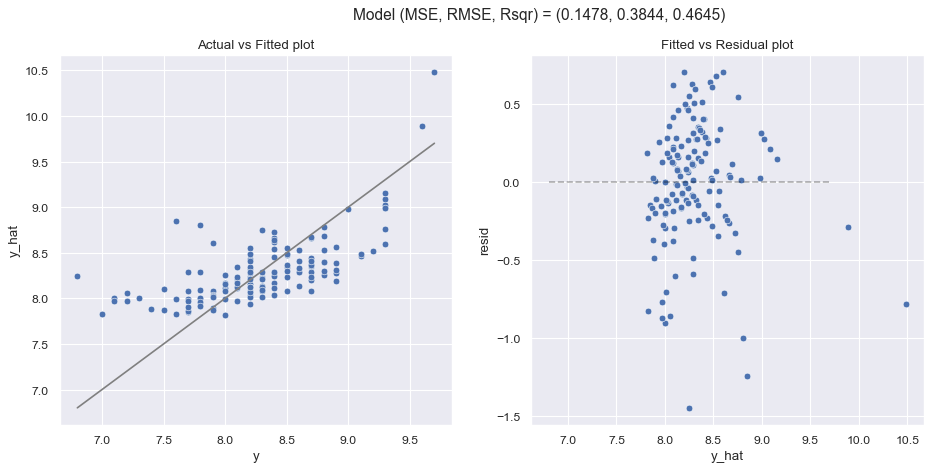

[ 7.24236269e+00  4.11291734e-04  2.64113882e-03  5.50076382e-04
 -1.23440456e-04 -1.34041258e-02]


In [80]:
# Tristans code but without character names

# Define headers to regress on
head = ['total_votes', 'n_lines', 'n_directions', 'n_words', 'n_speak_char']

# get regressing cols
X_train_ = X_train[head]
X_test_ = X_test[head]

# regress the regression 
test_model = LinearRegression()
test_model.fit(X_train_,y_train)

# use the regressed regression to predict
y_train_pred = test_model.predict(X_train_)
y_test_pred = test_model.predict(X_test_)

# Rsquared
print(r'Train $R^2$', r2_score(y_train, y_train_pred))
print(r'Test $R^2$', r2_score(y_test, y_test_pred))

model_fit(test_model, X_train_, y_train, plot = True)
print(get_coefs(test_model))

In the first model, the points in the actual vs fitted plot are much closer to the fitted line than the second mode, suggesting it is indeed better. For both residual plots the points seem to be equally distributed about 0, suggesting linearity assumption is indeed reasonable. Some points are quite far away from the 0 line suggesting the model struggles to deal with outliers, however this is slightly better in first plot. Finally R^2 value of first plot is better as well as MSE and RMSE.

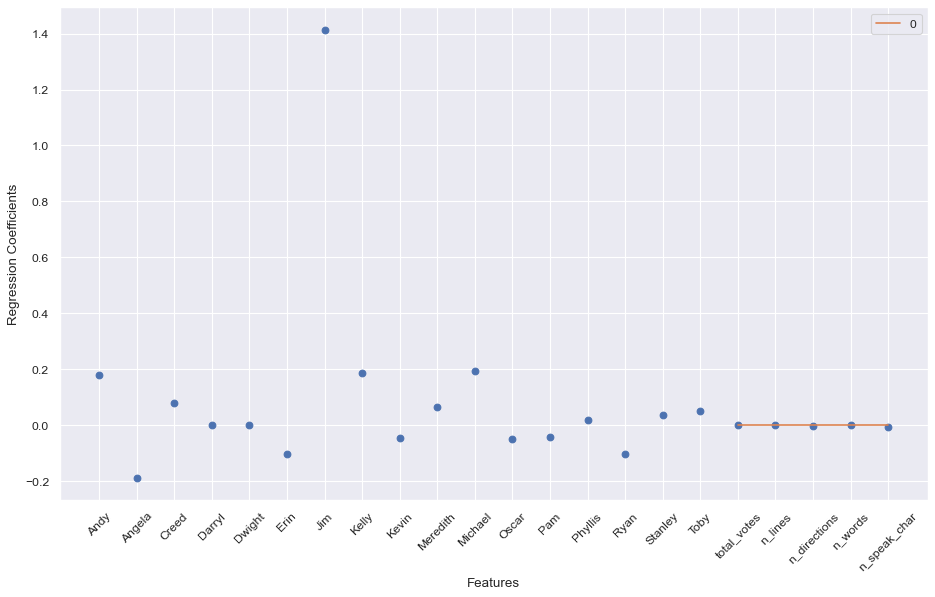

In [81]:
plt.plot(coeffs,'o')
plt.xticks(rotation=45)

plt.plot(head,[0]*len(head), label='0')

#plt.yscale('symlog')

plt.legend()
plt.ylabel('Regression Coefficients')
plt.xlabel('Features')
plt.show()


## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from

stackexchange

chatGPT

Tristan Pang
